In [1]:
import xarray as xr

from sklearn import preprocessing, model_selection, ensemble, svm, metrics

import numpy as np

import matplotlib.pyplot as plt

In [2]:
DATASET = xr.open_dataset('data/julia2018_resting/connectivity.nc')

In [3]:
_, classes = np.unique(DATASET['group'], return_inverse=True)
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [4]:

kinds = ['covariance', 'correlation', 'partial_correlation', 'tangent', 'precision']

valid_beh_subjects_mask = ~np.isnan(DATASET['inverse_efficiency_score_ms'].values)

y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(DATASET['group'])
y = y[valid_beh_subjects_mask]

cv = model_selection.StratifiedShuffleSplit(n_splits=100, test_size=.2)

scores = {}
for kind in kinds:
    scores[kind] = []
    
    # 1d-vectorize the connectivity matrix
    X = np.array([subj_conn[np.triu_indices_from(subj_conn, k=1)] 
                  for subj_conn in DATASET[f'{kind}_connectivity'].values])
    X = X[valid_beh_subjects_mask]
    
    for train, test in cv.split(X, y):
        classifier = ensemble.AdaBoostClassifier().fit(X[train], y[train])
        y_pred = classifier.predict(X[test])
        score = metrics.roc_auc_score(y[test], y_pred)
        # score = metrics.accuracy_score(y[test], y_pred)
        scores[kind].append(score)

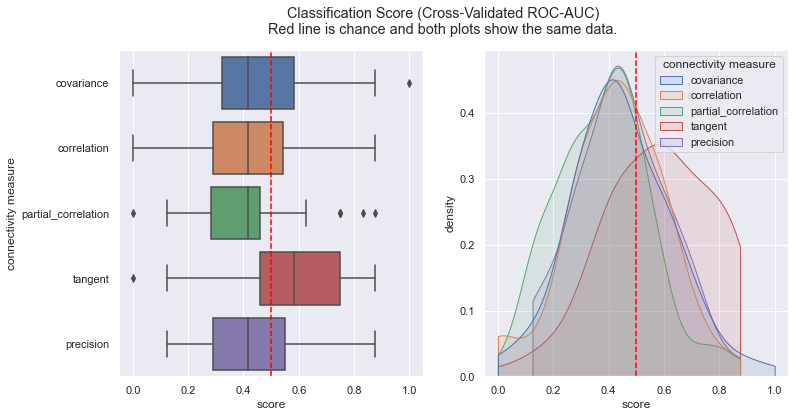

In [5]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

import pandas as pd

plotting_data = pd.DataFrame({
  'kind': kinds,
  'mean_score': [np.mean(scores[kind]) for kind in kinds],
  'std_score': [np.std(scores[kind]) for kind in kinds]
})

import seaborn as sns; sns.set()

scores_df = pd.DataFrame.from_dict(scores).melt(var_name='kind', value_name='score')


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# box/violin plot
sns.boxplot(data=scores_df, y='kind', x='score', orient='horizontal', ax=axes[0])
axes[0].set(ylabel='connectivity measure')

# dist plot
g = sns.kdeplot(
  data=scores_df, x='score', hue='kind',
  fill=True, clip=(0,1), alpha=.12, cut=0,
  ax=axes[1])

g.set(ylabel='density')
axes[1].get_legend().set_title('connectivity measure')

# plot chance line
axes[0].axvline(.5, color='red', linestyle='--')
axes[1].axvline(.5, color='red', linestyle='--')

plt.suptitle('Classification Score (Cross-Validated ROC-AUC)'
             '\nRed line is chance and both plots show the same data.')

plt.show()